In [135]:
!pip3 install matplotlib

In [136]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import collections
from enum import Enum
from typing import List, Optional
from dataclasses import dataclass, field

origData = []
MIN_FILTER_SIZE = 3
MAX_FILTER_SIZE = 301
FILTER_SIZE = 33
FIG_SIZE = (42, 13)
FRAME_SIZE = 180
FRAME_LEN = 160
DBL_EPSILON = sys.float_info.epsilon
DBL_MAX = sys.float_info.max

In [137]:
wfOrig = wave.open("raw_voice.wav", 'r')
origCh = wfOrig.getnchannels()
origSmpl = wfOrig.getsampwidth()
origRate = wfOrig.getframerate()
origNFrames = wfOrig.getnframes()
origData = wfOrig.readframes(origNFrames)
wfOrig.close()
print(f"Orig\n channels: {origCh}\n samples width: {origSmpl}\n frame rate: {origRate}\n frames: {origNFrames}\n data len: {len(origData)}")

Orig
 channels: 1
 samples width: 2
 frame rate: 8000
 frames: 1073741824
 data len: 485120


In [138]:
# def update_max(maxVal, val):
#     if (val> maxVal):
#         maxVal = val

# def update_value(newVal: float, oldVal: float, val: float) -> float:
#     return (val * newVal) + ((1.0 - val) * oldVal)

# # def setup_compress_thresh(threshold: float) -> float:
# #     if ((threshold > DBL_EPSILON) and (threshold < (1.0 - DBL_EPSILON))):
# #         current_threshold = threshold
# #         step_size = 1.0
# #         while (step_size > DBL_EPSILON):
# #             while (round()
        

# def frame_size(val1: int, val2: int) -> int:
#     frameSize = int(round(float(val1) * (float(val2) / 1000.0)))
#     return frameSize + (frameSize % 2)

# def bound(threshold: float, val: float) -> float:
#     return math.erf((math.sqrt(math.pi) / 2.0) * (val / threshold)) * threshold

# def fade(prevVal: float, nextVal: float, pos: int, fadeFactors) -> float:
#     return (fadeFactors[0][pos] * prevVal) + (fadeFactors[1][pos] * nextVal)

# def limit(minVal, val, maxVal):
#     return min(maxVal, max(minVal, val))

In [139]:
class GaussianFilter:
    m_sigma = float()
    m_weights = list()
    m_filterSize = int()
    
    def __init__(self, filterSize: int):
        self.m_filterSize = filterSize
        self.m_sigma = (((float(self.m_filterSize) / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        self.m_weights = np.zeros(filterSize)
        totalWeight = 0.0
        offset = int(self.m_filterSize / 2)
        c1 = 1.0 / (self.m_sigma * np.sqrt(2.0 * np.pi))
        c2 = 2.0 * np.pow(self.m_sigma, 2.0)
    
        for i in range(0, self.m_filterSize):
            x = i - offset
            # self.m_weights[i] = c1 * np.exp(np.pow(x, 2.0) * -1)
            self.m_weights[i] = c1 * math.exp(-x * x / c2)
            totalWeight += self.m_weights[i]
    
        adjust = 1.0 / totalWeight
        for i in range(0, self.m_filterSize):
            self.m_weights[i] *= adjust
    
        print(f"GaussFilter: filter size = {self.m_filterSize}, sigma = {self.m_sigma}")

    def apply(self, data) -> float:
        result = 0.0
        tsum = 0.0

        # for i in range(0, data.cqueue_size()):
            
        
        if (data.size() != self.m_filterSize):
            print("Input data wrong size")
            return result

        itr = 0
        for val in data:
            result += val * self.m_weights[itr]
            itr += 1
        
        return result


In [140]:
@dataclass
class LocalGain:
    max_gain: float
    threshold: float

class CQueue:
    def __init__(self):
        self.elements = None
        self.size = 0
        self.max_size = 0
        self.nb_elements = 0
    
    def __repr__(self):
        return f"CQueue(size={self.size}, max_size={self.max_size}, nb_elements={self.nb_elements})"

def cqueue_create(size: int, max_size: int) -> CQueue:
    if (max_size < size):
        return None
    resQ = CQueue()
    resQ.max_size = max_size
    resQ.size = size
    resQ.nb_elements = 0
    resQ.elements = [0.0] * max_size
    return resQ

def cqueue_size(q: CQueue) -> int:
    return q.nb_elements

def cqueue_empty(q: CQueue) -> bool:
    return q.nb_elements <= 0

def cqueue_enqueue(q: CQueue, element: float):
    if not (q.nb_elements < q.max_size):
        return
    q.elements[q.nb_elements] = element
    q.nb_elements += 1

def cqueue_peek(q: CQueue, index: int) -> float:
    if not (index < q.nb_elements):
        return
    return q.elements[index]

def cqueue_dequeue(q: CQueue):
    if cqueue_empty(q):
        return
    element = q.elements[0]
    q.elements = q.elements[1:] + [0.0]
    q.nb_elements -= 1
    return element

def cqueue_pop(q: CQueue):
    if cqueue_empty(q):
        return
    q.elements = q.elements[1:] + [0.0]
    q.nb_elements -= 1

var = cqueue_create(0, 5)
cqueue_enqueue(var, 42.0)
cqueue_enqueue(var, 2.0)
cqueue_enqueue(var, 3.0)
print(var)
elem = cqueue_dequeue(var)
print(elem, var)

CQueue(size=0, max_size=5, nb_elements=3)
42.0 CQueue(size=0, max_size=5, nb_elements=2)


In [141]:
# NOTE: frame->nb_samples == s->sample_advance == s->frame_len == self.m_frameLen
# NOTE: frame->extended_data[c] - сами данные

import random

class AGC:
    m_is_first_frame = True
    def __init__(self, channels: int, filterSize: int, sampleRate: int, frameLenMsec: int, maxAmplification: int):
        self.channels = channels
        self.filter_size = filterSize
        # self.m_sampleRate = sampleRate
        self.frame_len_msec = frameLenMsec
        self.frame_len = self.frame_size(sampleRate, self.frame_len_msec)
        self.prev_amplification_factor = np.ones(self.channels, dtype=float)
        self.dc_correction_value = np.ones(self.channels, dtype=float)

        self.gain_history_original = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        self.gain_history_minimum = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        self.gain_history_smoothed = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        self.threshold_history = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        
        # for c in range(0, self.channels):
        #     self.gain_history_original[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        #     self.gain_history_minimum[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        #     self.gain_history_smoothed[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        #     self.threshold_history[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        
        self.overlap = 0.0
        self.threshold = 0.0
        self.sample_advance = max(1, int(round(self.frame_len * (1.0 - self.overlap))))
        self.peak_value = 0.95
        self.max_amplification = maxAmplification # NOTE: коэф громкости

    def frame_size(self, sampleRate: int, frameLenMsec: int) -> int:
        frameSize = int(round(float(sampleRate) * (frameLenMsec / 1000.0)))
        return frameSize + (frameSize % 2)
    
    def filter_frame(self, frame) -> int:
        self.analyze_frame(frame)
        return 1

    def analyze_frame(self, frame) -> int:
        self.perform_dc_correction(frame)

        if (self.frame_len != self.sample_advance):
            pass
        else:
            # copy data frames
            self.update_gain_histories(frame)
            pass
        
        return 1

    def perform_dc_correction(self, frame):
        diff = 1.0 / self.frame_len
        for ch in range(0, self.channels):
            bypass = self.bypass_channel(frame, ch)
            current_average_value = 0.0
            prev_value = 0.0
            
            for i in range(0, self.frame_len):
                current_average_value += frame[i] * diff

            if (self.m_is_first_frame):
                prev_value = current_average_value
                self.dc_correction_value[ch] = current_average_value
            else:
                prev_value = self.dc_correction_value[ch]
                self.dc_correction_value[ch] = self.update_value(current_average_value, self.dc_correction_value[ch], 0.1)

            if (bypass):
                continue

            for i in range(0, self.frame_len):
                frame[i] -= self.fade(prev_value, self.dc_correction_value[ch], i, self.frame_len)
        
        self.m_is_first_frame = False

    def bypass_channel(self, frame, channel):
        return False

    def update_value(self, newVal: float, oldVal: float, aggressiveness: float) -> float:
        return aggressiveness * newVal + (1.0 - aggressiveness) * oldVal

    def fade(self, prevVal: float, nextVal: float, pos: int, length: int) -> float:
        step_size = 1.0 / length
        f0 = 1.0 - (step_size * (pos + 1.0))
        f1 = 1.0 - f0
        return f0 * prevVal + f1 * nextVal

    def update_gain_histories(self, frame) -> int:
        # channels = self.m_channels
        # start = int((channels * jobnr) / nb_jobs)
        # end = int((channels * (jobnr+1)) / nb_jobs)
        # for chnl in range(start, end):
        maxLocalGain = self.get_max_local_gain(frame, self.channels)
        self.update_gain_history(self.channels - 1, maxLocalGain)

    def update_gain_history(self, channel: int, gain: LocalGain):
        # TODO: продолжить тут
        if (cqueue_empty(self.gain_history_original[channel])):
            pre_fill_size = int(self.filter_size / 2)
            initial_value = float(min(1.0, gain.max_gain))
            self.prev_amplification_factor[channel] = initial_value
            while (cqueue_size(self.gain_history_original[channel]) < pre_fill_size):
                cqueue_enqueue(self.gain_history_original[channel], initial_value)
                cqueue_enqueue(self.threshold_history[channel], gain.threshold)

        cqueue_enqueue(self.gain_history_original[channel], gain.max_gain)

        while (cqueue_size(self.gain_history_original[channel]) >= self.filter_size):
            minimum = 0.0
            if (cqueue_empty(self.gain_history_minimum[channel])):
                pre_fill_size = int(self.filter_size / 2)
                initial_value = 1.0
                inputVal = pre_fill_size
                while (cqueue_size(self.gain_history_minimum[channel]) < pre_fill_size):
                    inputVal += 1
                    initial_value = float(min(initial_value, cqueue_peek(self.gain_history_original[channel], inputVal)))
                    cqueue_enqueue(self.gain_history_minimum[channel], initial_value)
            minimum = self.minimum_filter(self.gain_history_original[channel])
            cqueue_enqueue(self.gain_history_minimum[channel], minimum)
            cqueue_enqueue(self.threshold_history[channel], gain.threshold)
            cqueue_pop(self.gain_history_original[channel])

        while (cqueue_size(self.gain_history_minimum[channel]) >= self.filter_size):
            smoothed = 0.0
            limit = 0.0
            # smoothed = gaussian_filter()
            smoothed = random.uniform(1.0, 10.0)
            limit = cqueue_peek(self.gain_history_original[channel], 0)
            smoothed = min(smoothed, limit)
            cqueue_enqueue(self.gain_history_smoothed[channel], smoothed)
            cqueue_pop(self.gain_history_minimum[channel])
            cqueue_pop(self.threshold_history[channel])
                    
    def get_max_local_gain(self, frame, channel: int) -> LocalGain:
        peak_magnitude = self.find_peak_magnitude(frame, channel)
        maximum_gain = self.peak_value / peak_magnitude
        rms_gain = DBL_MAX
        target_gain = DBL_MAX
        maxGain = self.bound(self.max_amplification, min(target_gain, min(maximum_gain, rms_gain)))
        gain = LocalGain(max_gain=maxGain, threshold=(peak_magnitude > self.threshold))
        return gain

    def find_peak_magnitude(self, frame, channel: int) -> float:
        maxVal = DBL_EPSILON
        if (-1 == channel):
            for c in range(0, self.channels):
                for i in range(0, self.frame_len):
                    maxVal = max(maxVal, math.fabs(frame[i]))
        else:
            for i in range(0, self.frame_len):
                maxVal = max(maxVal, math.fabs(frame[i]))
                
        return maxVal

    def bound(self, threshold: float, val: float) -> float:
        # CONST = 0.8862269254527580136490837416705725913987747280611935; # NOTE: sqrt(PI) / 2.0
        CONST = math.sqrt(math.pi) / 2
        return (math.erf(CONST * (val / threshold)) * threshold)

    def minimum_filter(self, q: CQueue) -> float:
        minVal = DBL_MAX
        for i in range(0, cqueue_size(q)):
            minVal = min(minVal, cqueue_peek(q, i))
        return minVal


In [142]:
# class CQueue:
#     def __init__(self, max_size: int):
#         self.elements = []                # Dynamic list
#         self.size = 0                     # Current number of elements  
#         self.max_size = max_size          # Maximum capacity
#         self.nb_elements = 0              # Redundant with size, but kept for C struct compatibility
    
#     def cqueue_size(self):
#         return self.nb_elements

#     def cqueue_empty(self):
#         return (self.nb_elements <= 0)

#     def cqueue_enqueue(self, element):
#         assert self.nb_elements < self.max_size, "Queue overflow: cannot enqueue to full queue"
#         self.elements[self.nb_elements] = element
#         self.nb_elements += 1
#         return 0

#     def cqueue_peek(self, index: int):
#         assert index < self.nb_elements, "Index out of bounds"
#         return self.elemnts[index]

#     def cqueue_dequeue(self, element):
#         assert not self.cqueue_empty(), "Queue underflow: cannot dequeue from empty queue"
        
#         element = self.elements[0]

#         for i in range(self.nb_elements - 1):
#             self.elements[i] = self.elements[i + 1]
        
#         self.nb_elements -= 1
#         return element

#     def cqueue_pop(self):
#         assert not self.empty(), "Queue underflow: cannot pop from empty queue"

#         for i in range(self.nb_elements - 1):
#             self.elements[i] = self.elements[i + 1]

#         self.nb_elements -= 1
#         return 0

#     def cqueue_resize(self, new_size: int):
#         assert self.max_size >= new_size, "New size exceeds maximum capacity"
#         assert new_size >= MIN_FILTER_SIZE, f"New size must be at least {MIN_FILTER_SIZE}"

#         if (new_size > self.nb_elements):
#             side = (new_size - self.nb_elements) // 2

#             for i in range(self.nb_elements - 1, -1, -1):
#                 self.elements[i + side] = self.elements[i]

#             if side > 0 and self.nb_elements > 0:
#                 fill_value = self.elements[side]
#                 for i in range(side):
#                     self.elements[i] = fill_value

#             self.nb_elements = new_size - 1 - side
#         else:
#             count = (self.size - new_size + 1) // 2
#             for _ in range(count):
#                 if (not self.empty()):
#                     self.pop()

#         self.size = new_size

#     def minimum_filter(self):
#         minVal = sys.float_info.epsilon
        
#         for i in range(0, self.size()):
#             minVal = min(minVal, self.cqueue_peek(i))
        
#         return minVal

# def cqueue_create(size, max_size: int):
#     if max_size < size:
#         return None

#     try:
#         elements = [0.0] * max_size
#     except MemoryError:
#         return None

#     queue = CQueue.__new__(CQueue)  # Create instance without calling __init__
#     queue.elements = elements
#     queue.size = size
#     queue.max_size = max_size
#     queue.nb_elements = 0
#     return queue

In [143]:
# @dataclass
# class local_gain:
#     max_gain: float
#     threshold: float

# class VarName(Enum):
#     VAR_CH = 0
#     VAR_SN = 1
#     VAR_NB_CHANNELS = 2
#     VAR_T = 3
#     VAR_SR = 4
#     VAR_P = 5
#     VAR_VARS_NB = 6

# def minimum_filter(q: CQueue) -> float:
#     min_val = DBL_MAX
#     for i in range(q.size_queue()):
#         min_val = min(min_val, q.peek(i))
#     return min_val

# @dataclass
# class AudioNormalizer:
#     class_obj: Optional[object]  # Placeholder for AVClass*
#     queue: Optional[object]  # Placeholder for FFBufQueue
    
#     frame_len: int
#     frame_len_msec: int
#     filter_size: int
#     dc_correction: bool
#     channels_coupled: bool
#     alt_boundary_mode: bool
#     overlap: float
#     expr_str: Optional[str]
    
#     peak_value: float
#     max_amplification: float
#     target_rms: float
#     compress_factor: float
#     threshold: float
#     prev_amplification_factor: Optional[np.ndarray]  # Assuming array of floats
#     dc_correction_value: Optional[np.ndarray]
#     compress_threshold: Optional[np.ndarray]
#     weights: Optional[np.ndarray]
    
#     channels: int
#     sample_advance: int
#     eof: int
#     channels_to_filter: Optional[str]
#     ch_layout: Optional[object]  # Placeholder for AVChannelLayout
#     pts: int
    
#     gain_history_original: Optional[List[Optional[CQueue]]]
#     gain_history_minimum: Optional[List[Optional[CQueue]]]
#     gain_history_smoothed: Optional[List[Optional[CQueue]]]
#     threshold_history: Optional[List[Optional[CQueue]]]
    
#     is_enabled: Optional[CQueue]
    
#     window: Optional[object]  # Placeholder for AVFrame
#     expr: Optional[object]  # Placeholder for AVExpr
    
#     var_values: List[float] = field(default_factory=lambda: [0.0] * VarName.VAR_VARS_NB)
    
#     m_gauss = None

#     def __init__(self, channels: int, sampleRate: int, frameLenMsec: int, filterSize: int,
#                  peakValue: float, maxAmplification: float, targetRms: float, compressThresh: float, altBoundaryMode: bool):
#         self.m_channels = channels
#         self.m_sampleRate = sampleRate
#         self.m_frameLen = frame_size(sampleRate, frameLenMsec)
#         self.m_filterSize = limit(3, filterSize, 301)
#         self.m_prefillLen = int(self.m_filterSize / 2)
#         self.m_delay = self.m_frameLen * self.m_filterSize
#         self.m_peakValue = limit(0.01, peakValue, 1.0)
#         self.m_maxAmplification = limit(1.0, maxAmplification, 100.0)
#         self.m_targetRMS = limit(0.0, targetRms, 1.0)
#         self.m_altBoundaryMode = altBoundaryMode
#         self.m_fadeFactors = np.zeros((2, self.m_frameLen))
        
#         dStepSize = 1.0 / float(self.m_frameLen)
#         for i in range(0, self.m_frameLen):
#             self.m_fadeFactors[0][i] = (1.0 - (dStepSize * float(i + 1)))
#             self.m_fadeFactors[1][i] = (1.0 - self.m_fadeFactors[0][i])

#         m_gauss = GaussianFilter(FILTER_SIZE)

#         print(f"Params:\n m_channels = {self.m_channels}\n m_sampleRate = {self.m_sampleRate}\n m_frameLen = {self.m_frameLen}\n m_filterSize = {self.m_filterSize}\n m_prefillLen = {self.m_prefillLen}\n m_delay = {self.m_delay}\n m_peakValue = {self.m_peakValue}\n m_maxAmplification = {self.m_maxAmplification}\n m_targetRMS = {self.m_targetRMS}\n m_altBoundaryMode = {self.m_altBoundaryMode}\n m_fadeFactors = {self.m_fadeFactors}")

#     def frame_size(self, sample_size: int, frame_len_msec: int) -> int:
#         frameSize = math.ceil(float(sample_size) * (frame_len_msec / 1000.0)) # NOTE: вместо ceil() - lrint()
#         return (frameSize + (frameSize % 2))

#     def fade(self, prevVal: float, nextVal: float, pos: int, length: int) -> float:
#         step_size = 1.0 / length
#         f0 = 1.0 - (step_size * (pos + 1.0))
#         f1 = 1.0 - f0
#         return (f0 * prevVal + f1 * nextVal)

#     def bound(self, threshold: float, val: float) -> float:
#         # CONST = 0.8862269254527580136490837416705725913987747280611935; # NOTE: sqrt(PI) / 2.0
#         CONST = math.sqrt(math.pi) / 2
#         return (math.erf(CONST * (val / threshold)) * threshold)

#     def find_peak_magnitude(self, frame, channel: int) -> float:
#         MAX = sys.float_info.epsilon

#         if (-1 == channel):
#             for chnl in range(0, self.m_channels):
#                 dataPtr = frame[chnl]
#                 for i in range(0, self.m_frameLen):
#                     MAX = max(MAX, math.fabs(dataPtr[i]))
#         else:
#             dataPtr = frame[channel]
#             for i in range(0, self.m_frameLen):
#                 MAX = max(MAX, math.fabs(dataPtr[i]))
            
#         return MAX

#     def compute_frame_rms(self, frame, channel: int) -> float:
#         rms_value = 0.0

#         if (-1 == channel):
#             for chnl in range(0, self.m_channels):
#                 dataPtr = frame[chnl]
#                 for i in range(0, self.m_frameLen):
#                     rms_value += math.pow(dataPtr[i], 2)

#             rms_value /= (self.m_frameLen * self.m_channels)

#         else:
#             dataPtr = frame[channel]
#             for i in range(0, self.m_frameLen):
#                 rms_value += math.pow(dataPtr[i], 2)

#             rms_value /= self.m_fameLen
            
#         return max(math.sqrt(rms_value), sys.float_info.epsilon)

#     def get_max_local_gain(self, frame, channel: int) -> local_gain:
#         peak_magnitude = find_peak_magnitude(frame, channel)
#         maximum_gain = self.peak_value / peak_magnitude
#         rms_gain = (self.target_rms / compute_frame_rms(frame, channel)) if s.target_rms > DBL_EPSILON else DBL_MAX
#         target_gain = DBL_MAX
#         thr = peak_magnitude > self.threshold
#         maxGain = bound(self.max_amplification, min(target_gain, min(maximum_gain, rms_gain)))
#         gain = local_gain(threshold=thr, max_gain=maxGain)
#         return gain

#     def update_gain_history(self, channel: int, gain: local_gain):
#         if (self.gain_history_original[channel].empty()):
#             pre_fill_size = int(self.filter_size / 2)
#             initial_value = gain.max_gain if self.alt_boundary_mode else min(1.0, gain.max_gain)
#             self.prev_amplification_factor[channel] = initial_value

#             while (self.gain_history_original[channel].size() < pre_fill_size):
#                 self.gain_history_original[channel].enqueue(initial_value)
#                 self.threshold_history[channel].enqueue(gain.threshold)

#         self.gain_history_original[channel].enqueue(gain.max_gain)

#         while (self.gain_history_original[channel].size() >= self.filter_size):
#             minimum = 0.0
#             if (self.gain_history_minimum[channel].empty()):
#                 pre_fill_size = self.filter_size / 2
#                 initial_value = (self.gain_history_original[channel].peek(0)) if self.alt_boundary_mode else 1.0
#                 inputVal = pre_fill_size

#                 while (self.gain_history_minimum[channel].size() < pre_fill_size):
#                     inputVal += 1
#                     initial_value = min(initial_value, self.gain_history_original[channel].peek(inputVal))
#                     self.gain_history_minimum[channel].enqueue(initial_value)

#             minimum = minimum_filter(self.gain_history_original[channel])
#             self.gain_history_minimum[channel].enqueue(minimum)
#             self.threshold_history[channel].enqueue(gain.threshold)
#             self.gain_history_original[channel].pop()

#         while (self.gain_history_minimum[channel].size() >= self.filter_size):
#             smoothed = gaussian_filter(self.gain_history_minimum[channel], self.threshold_history[channel])
#             limit = self.gain_history_original[channel].peek(0)
#             smoothed = min(smoothed, limit)
#             self.gain_history_smoothed[channel].enqueue(smoothed)
#             self.gain_history_minimum[channel].pop()
#             self.threshold_history[channel].pop()

#     def update_gain_histories(self, frame, jobnr: int, nb_jobs: int) -> int:
#         channels = self.channels
#         start = int((channels * jobnr) / nb_jobs)
#         end = int((channels * (jobnr + 1)) / nb_jobs)

#         for i in range(start, end):
#             update_gain_history(i, get_max_local_gain(frame, i))
        
#     def perform_dc_correction(self, frame):
#         diff = 1.0 / self.frame_len
#         is_first_frame = self.gain_history_original[0].empty()

#         for c in range(0, self.channels):
#             dst_ptr = frame[c]
#             current_average_value = 0.0
#             prev_value = 0.0

#             for i in range(0, self.frame_len):
#                 current_average_value += dst_ptr[i] * diff

#             prev_value = current_average_value if is_first_frame else self.dc_correction_value[c]
#             self.dc_correction_value[c] = current_average_value if is_first_frame else update_value(current_average_value, self.dc_correction_value[c], 0.1)

#             for i in range(0, self.frame_len):
#                 dst_ptr[i] -= fade(prev_value, self.dc_correction_value[i], i, self.frame_len)

#     def amplify_channel(self, frameIn, frameOut, enabled: int, c: int):
#         src_ptr = frameIn[c]
#         dst_ptr = frameOut[c]
#         current_amplification_factor = 0.0
#         self.gain_history_smoothed[c].dequeue(current_amplification_factor)
        
#         for i in range(0, self.frame_len):
#             amplification_factor = fade(self.prev_amplification_factor[c], current_amplification_factor, i, self.frame_len)
#             dst_ptr[i] = src_ptr[i] * amplification_factor

#         self.prev_amplification_factor[c] = current_amplification_factor

#     # def amplify_channels(self, 

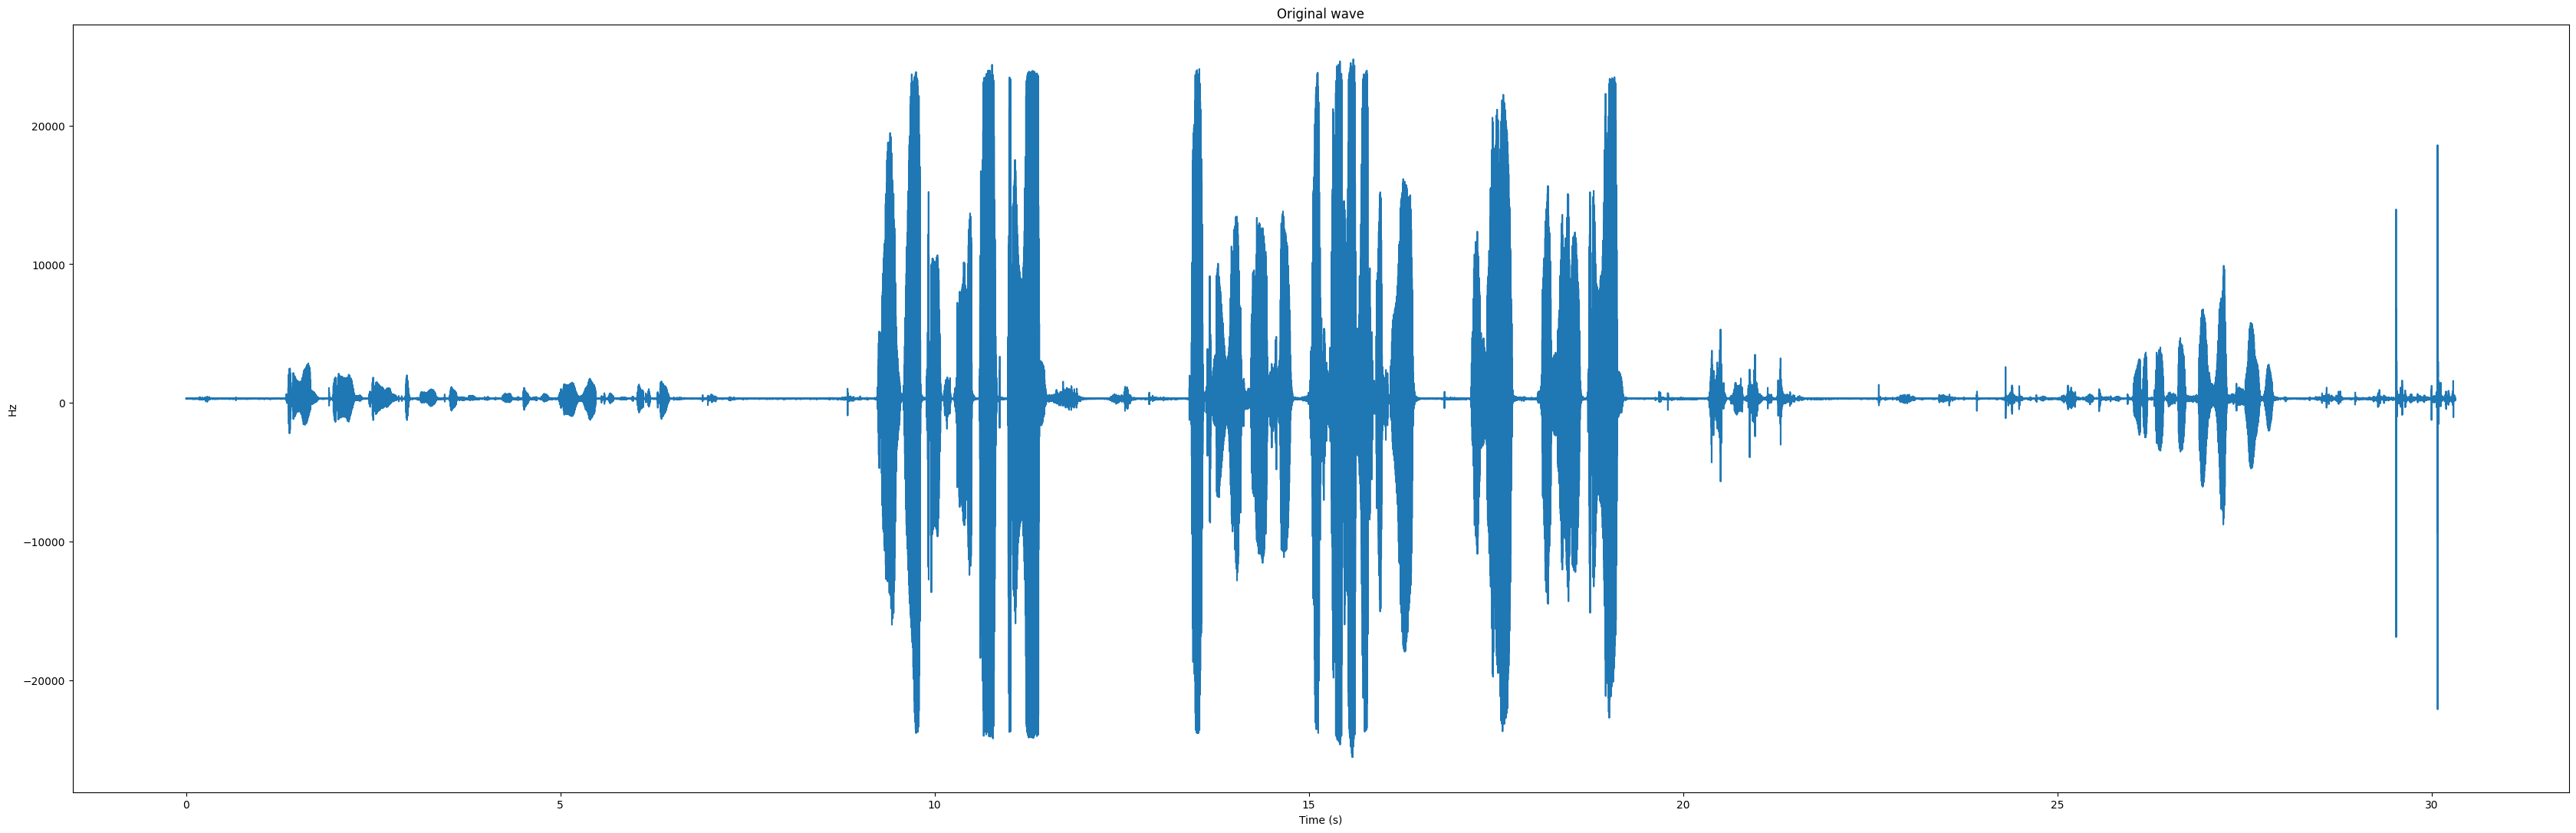

In [144]:
origPlotData = np.frombuffer(origData, np.int16)
origDataLen = len(origPlotData)
time = np.linspace(0, origDataLen / origRate, num = origDataLen)
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Original wave")
plt.plot(time, origPlotData)
plt.show()

In [145]:
processedData = origPlotData.copy()
processedDataLen = len(processedData)
print(f"len = {processedDataLen}")
STEP = 20
flag = True
MAX_AMPLIFICATION = 100

agc = AGC(origCh, FILTER_SIZE, origRate, STEP, MAX_AMPLIFICATION)

for i in range(0, processedDataLen, agc.frame_len):
    subStep = i + agc.frame_len
    if (subStep >= processedDataLen):
        break

    # TODO: передавать в обработку data[i, subStep]
    agc.filter_frame(processedData[i:subStep])
    
    # for j in range(i, subStep):
    #     # processedData[j] = np.iinfo(np.int16).max if flag else np.iinfo(np.int16).min
    #     processedData[j] += 500

    if flag:
        flag = False
    else:
        flag = True

len = 242560


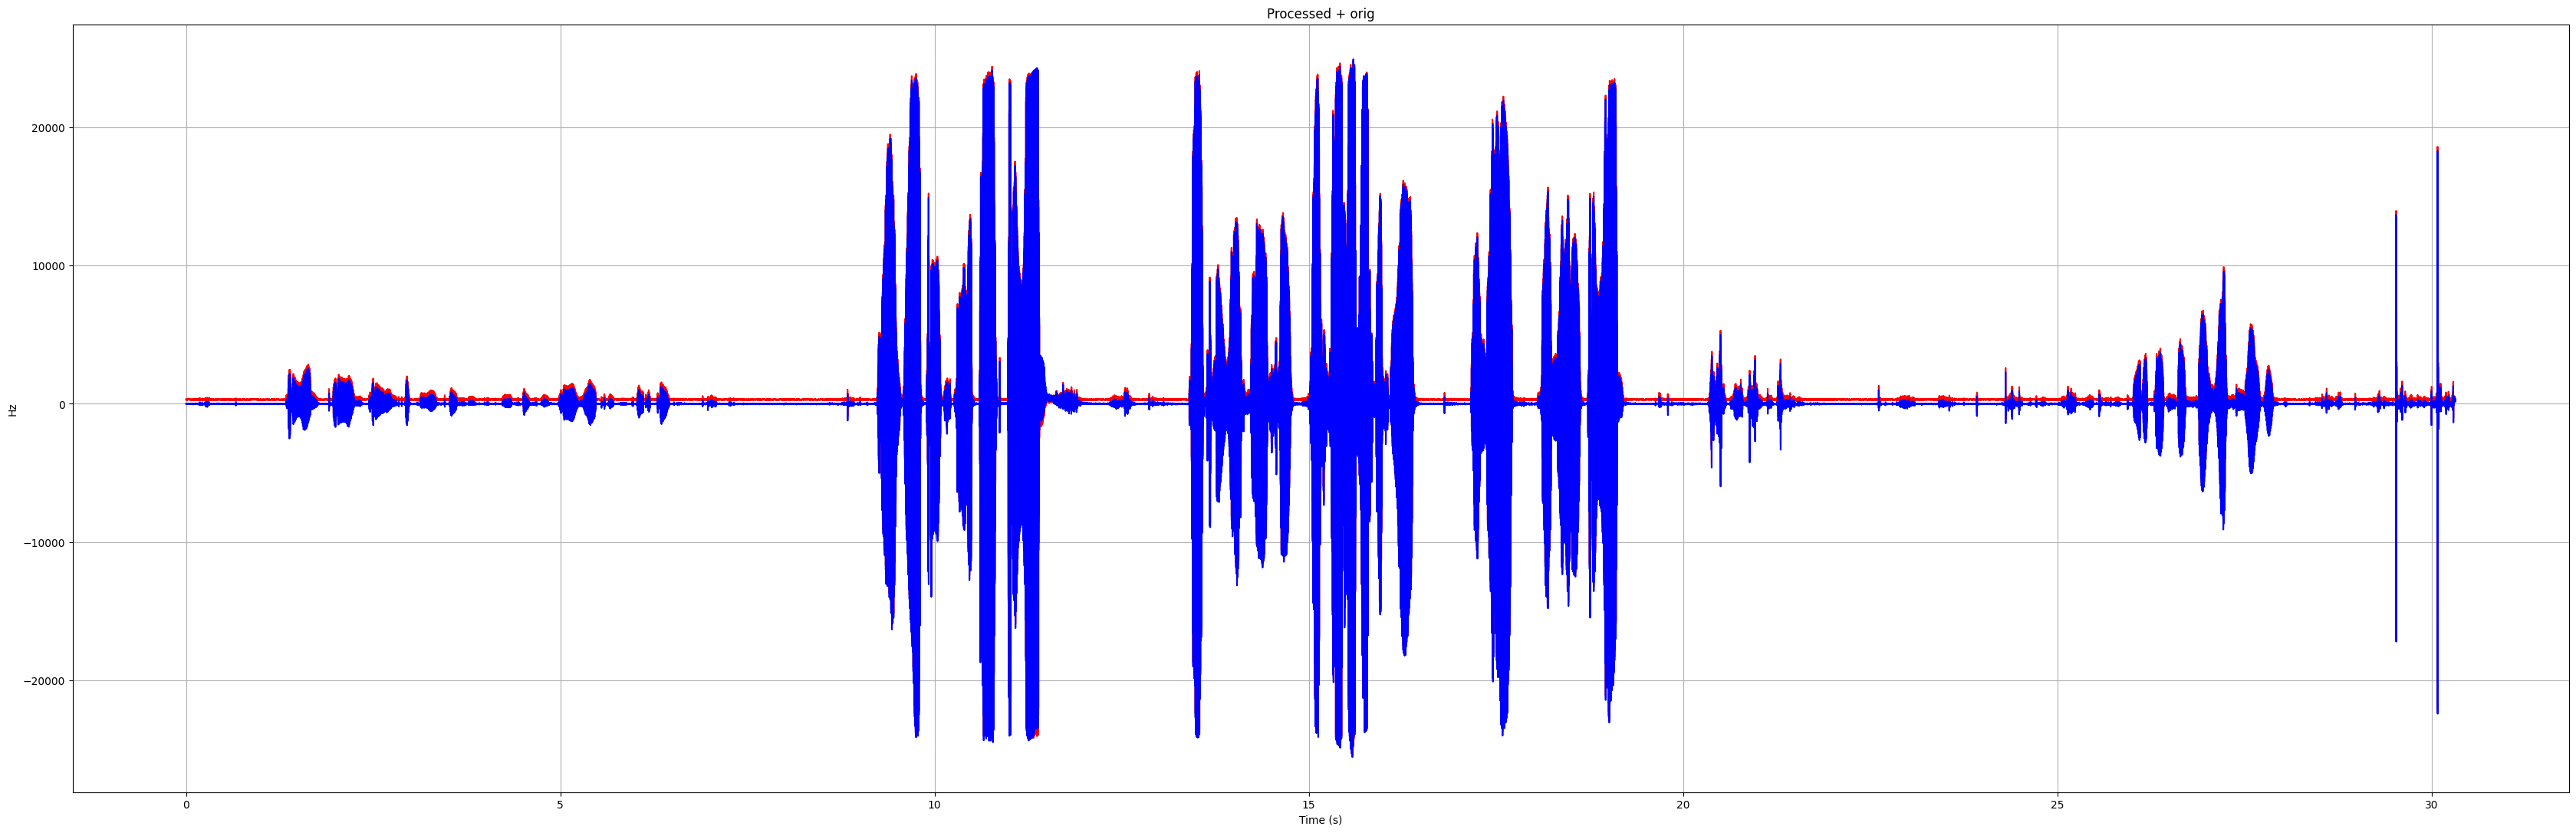

In [146]:
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Processed + orig")
plt.plot(time, origPlotData, color = 'r')
plt.plot(time, processedData, color = 'b')
plt.grid(True)
plt.show()